### 13장. 생성 모델
#### GAN 구현
- MNIST 데이터셋 사용하여 파이토치로 구현

In [ ]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap13/data.zip 데이터 불러오기

Saving data.zip to data.zip


In [ ]:
!unzip data.zip -d data/  # data 폴더 만들어 압축 풀기

Archive:  data.zip
   creating: data/MNIST/
   creating: data/MNIST/processed/
  inflating: data/MNIST/processed/test.pt  
  inflating: data/MNIST/processed/training.pt  
   creating: data/MNIST/raw/
  inflating: data/MNIST/raw/t10k-images-idx3-ubyte  
  inflating: data/MNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: data/MNIST/raw/t10k-labels-idx1-ubyte  
  inflating: data/MNIST/raw/t10k-labels-idx1-ubyte.gz  
  inflating: data/MNIST/raw/train-images-idx3-ubyte  
  inflating: data/MNIST/raw/train-images-idx3-ubyte.gz  
  inflating: data/MNIST/raw/train-labels-idx1-ubyte  
  inflating: data/MNIST/raw/train-labels-idx1-ubyte.gz  


In [ ]:
# 라이브러리 호출
import imageio  # 이미지 데이터를 읽고 쓸 수 있는 쉬운 인터페이스 제공하는 라이브러리
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pylab as plt
import matplotlib

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')  # stylesheet 변경하여 사용 - 'ggplot' : 격자무늬 백그라운드 삽입
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 변수 값 설정
batch_size = 512
epochs = 200
sample_size = 64  # 노이즈 벡터 사용하여 가짜 이미지 생성
nz = 128  # 잠재 벡터 크기
k = 1 # 판별자에 적용할 스텝 수

- `sample_size` : 생성자에 제공할 고정 크기의 노이즈 벡터에 대한 크기.
- `nz` : 잠재 벡터의 크기, 이는 생성자의 입력 크기와 동일해야 함.
- `k` : 판별자에 적용할 스텝 수, 1로 지정한 이유는 훈련 비용 최소화하기 위함.



In [ ]:
# MNIST 내려받은 후 정규화
transform = transforms.Compose([
                                transforms.ToTensor(), # 이미지 텐서로 변환
                                transforms.Normalize((0.5,),(0.5,)),
                                # 이미지를 평균 0.5, 표준편차 0.5 되도록 정규화
])

train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 생성자 네트워크 생성
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)
        # 생성자 네트워크의 반환값은 '배치 크기x1x28x28'이 됨.

In [ ]:
# 판별자 네트워크 생성
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784  # 판별자의 입력 크기
        self.main = nn.Sequential(
            # 판별자 역시 선형 계층과 리키렐루 활성화 함수로 구성
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)   # 이미지가 진짜인지 가짜인지 분류하는 값 반환

In [ ]:
# 생성자와 판별자 네크워크 초기화
# 생성자는 잠재 벡터 nz라는 변수를 파라미터로 전달해야 함.
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [ ]:
# 옵티마이저와 손실 함수 정의
optim_g = optim.Adam(generator.parameters(), lr = 0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr = 0.0002)

criterion = nn.BCELoss()

losses_g = []  # 매 에포크마다 발생하는 생성자 오차 저장하기 위한 리스트형 변수
losses_d = []  # 매 에포크마다 발생하는 판별자 오차 저장하기 위한 리스트형 변수
images = []  # 생성자에 의해 생성되는 이미지 저장하기 위한 리스트형 변수

In [ ]:
# 생성된 이미지 저장 함수 정의
# 이미지가 생성되는 과정을 이해할 수 있도록 시각화하여 보여 줌.
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# 판별자 학습을 위한 함수
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)  # 배치 크기 정보 얻기
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    # 진짜 데이터를 판별자에 제공하여 학습한 결과와 진짜 데이터의 레이블 이용하여 오차 계산
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    # 가짜 데이터를 판별자에 제공하여 학습한 결과와 가짜 데이터의 레이블 이용하여 오차 계산
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake
    # 진짜 데이터와 가짜 데이터의 오차 합쳐진 최종 오차 반환

- `real_label`, `fake_label` : 모델 훈련을 위해 진짜 이미지와 생성자에서 생성한 가짜 이미지가 필요. 또한 레이블 정보도 필요한데, 레이블 정보는 텐서 형태를 가져야 하며 배치 크기와도 동일해야 함. 각각 진짜 데이터, 가짜 데이터에 대한 레이블 생성.
- `torch.ones(b_size, 1)` : 1 값을 가진 (b_size x 1) 크기의 텐서를 생성.

In [ ]:
# 생성자 학습을 위한 함수
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
!mkdir img #img 폴더 만들기

mkdir: cannot create directory ‘img’: File exists


- `real_label = torch.ones(b_size, 1).to(device)` : 생성자 네트워크에서는 가짜 데이터만 사용하고 있는데, 생성자 입장에서는 가짜 데이터가 실제로 진짜라는 것에 주의.

In [ ]:
# 모델 학습
generator.train()  # 생성자를 학습 모드로 설정
discriminator.train()  # 판별자를 학습 모드로 설정

for epoch in range(epochs):
    loss_g = 0.0  # 생성자 오차를 추적(저장)하기 위한 변수
    loss_d = 0.0  # 판별자 오차를 추적(저장)하기 위한 변수
    for idx, data in tqdm(enumerate(train_loader),
                          total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data  # 학습을 위한 이미지 데이터 가져옴.
        image = image.to(device)  # 데이터셋이 CPU/GPU 장치 사용하도록 지정
        b_size = len(image)
        for step in range(k):
        # k(1) 스텝 수에 따라 판별자 실행, 이때 k 수를 증가시킬 수 있지만 학습 시간 길어질 수 있음.
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)  # 생성자 학습
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    # 생성자 이용하여 새로운 이미지 생성하고 CPU 장치 이용하여 디스크에 저장
    generated_img = make_grid(generated_img)  # 이미지를 그리드 형태로 표현
    save_generator_image(generated_img, "./img/gen_img{epoch}.png")
    # 생성된 이미지(텐서) 디스크에 저장
    images.append(generated_img)
    epoch_loss_g = loss_g / idx  # 에포크에 대한 총 생성자 오차 계산
    epoch_loss_d = loss_d / idx    # 에포크에 대한 총 판별자 오차 계산
    losses_g.append(loss_g)
    losses_d.append(loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
118it [00:12,  9.77it/s]                         


Epoch 0 of 200
Generator loss: 1.33967149, Discriminator loss: 0.88638353


118it [00:12,  9.63it/s]                         


Epoch 1 of 200
Generator loss: 2.09944582, Discriminator loss: 1.40294945


118it [00:12,  9.37it/s]                         

Epoch 2 of 200
Generator loss: 5.03607798, Discriminator loss: 0.45133102



118it [00:12,  9.52it/s]                         

Epoch 3 of 200
Generator loss: 2.02879214, Discriminator loss: 1.00099814



118it [00:12,  9.30it/s]                         

Epoch 4 of 200
Generator loss: 1.32876909, Discriminator loss: 1.23041654



118it [00:12,  9.62it/s]                         

Epoch 5 of 200
Generator loss: 1.55025291, Discriminator loss: 1.17396092



118it [00:12,  9.31it/s]                         

Epoch 6 of 200
Generator loss: 1.64928949, Discriminator loss: 1.27658439



118it [00:12,  9.22it/s]                         


Epoch 7 of 200
Generator loss: 1.32605183, Discriminator loss: 1.01079011


118it [00:11,  9.86it/s]                         

Epoch 8 of 200
Generator loss: 1.16500235, Discriminator loss: 1.20365727



118it [00:12,  9.56it/s]                         

Epoch 9 of 200
Generator loss: 0.98714280, Discriminator loss: 1.34477985



118it [00:12,  9.61it/s]                         

Epoch 10 of 200
Generator loss: 0.82862312, Discriminator loss: 1.22879279



118it [00:12,  9.33it/s]                         


Epoch 11 of 200
Generator loss: 1.63170636, Discriminator loss: 0.94414908


118it [00:12,  9.37it/s]                         

Epoch 12 of 200
Generator loss: 2.31384230, Discriminator loss: 0.98376673



118it [00:11,  9.84it/s]                         

Epoch 13 of 200
Generator loss: 1.91076005, Discriminator loss: 1.03501475



118it [00:11,  9.89it/s]                         

Epoch 14 of 200
Generator loss: 1.89640617, Discriminator loss: 0.85692000



118it [00:11, 10.09it/s]                         

Epoch 15 of 200
Generator loss: 2.04948854, Discriminator loss: 0.94533885



118it [00:11, 10.05it/s]                         

Epoch 16 of 200
Generator loss: 2.21280646, Discriminator loss: 0.81087017



118it [00:11, 10.13it/s]                         

Epoch 17 of 200
Generator loss: 2.02859497, Discriminator loss: 0.81868547



118it [00:12,  9.20it/s]                         

Epoch 18 of 200
Generator loss: 1.89782727, Discriminator loss: 0.81108820



118it [00:12,  9.54it/s]                         


Epoch 19 of 200
Generator loss: 2.05191135, Discriminator loss: 0.83466089


118it [00:10, 10.75it/s]                         

Epoch 20 of 200
Generator loss: 1.56621397, Discriminator loss: 0.91826040



118it [00:11, 10.34it/s]                         

Epoch 21 of 200
Generator loss: 2.45576048, Discriminator loss: 0.67792284



118it [00:11, 10.30it/s]                         

Epoch 22 of 200
Generator loss: 1.78272891, Discriminator loss: 0.89708376



118it [00:11, 10.23it/s]                         

Epoch 23 of 200
Generator loss: 1.78619158, Discriminator loss: 0.77987194



118it [00:11, 10.24it/s]                         

Epoch 24 of 200
Generator loss: 2.27142787, Discriminator loss: 0.53619123



118it [00:11, 10.32it/s]                         

Epoch 25 of 200
Generator loss: 2.36626291, Discriminator loss: 0.75666195



118it [00:11, 10.02it/s]                         

Epoch 26 of 200
Generator loss: 2.02328181, Discriminator loss: 0.65521544



118it [00:11, 10.14it/s]                         

Epoch 27 of 200
Generator loss: 2.25639820, Discriminator loss: 0.65394783



118it [00:11,  9.90it/s]                         


Epoch 28 of 200
Generator loss: 2.29194450, Discriminator loss: 0.73140961


118it [00:14,  7.90it/s]                         


Epoch 29 of 200
Generator loss: 2.13118529, Discriminator loss: 0.67393434


118it [00:13,  8.81it/s]                         

Epoch 30 of 200
Generator loss: 2.18528557, Discriminator loss: 0.77548957



118it [00:15,  7.52it/s]                         

Epoch 31 of 200
Generator loss: 1.99026024, Discriminator loss: 0.73913854



118it [00:13,  8.69it/s]                         

Epoch 32 of 200
Generator loss: 2.43121099, Discriminator loss: 0.57805443



118it [00:12,  9.53it/s]                         

Epoch 33 of 200
Generator loss: 2.38314176, Discriminator loss: 0.64409512



118it [00:11, 10.32it/s]                         

Epoch 34 of 200
Generator loss: 2.00071383, Discriminator loss: 0.75571483



118it [00:11, 10.10it/s]                         

Epoch 35 of 200
Generator loss: 2.64304090, Discriminator loss: 0.51573235



118it [00:12,  9.58it/s]                         

Epoch 36 of 200
Generator loss: 2.59072256, Discriminator loss: 0.65368336



118it [00:12,  9.68it/s]                         

Epoch 37 of 200
Generator loss: 2.68329716, Discriminator loss: 0.55342668



118it [00:13,  8.96it/s]                         

Epoch 38 of 200
Generator loss: 2.95651293, Discriminator loss: 0.58866233



118it [00:14,  8.39it/s]                         

Epoch 39 of 200
Generator loss: 2.61064911, Discriminator loss: 0.59925801



118it [00:12,  9.23it/s]                         

Epoch 40 of 200
Generator loss: 3.08943129, Discriminator loss: 0.45836857



118it [00:12,  9.73it/s]                         

Epoch 41 of 200
Generator loss: 3.22377849, Discriminator loss: 0.43069473



118it [00:11,  9.93it/s]                         


Epoch 42 of 200
Generator loss: 2.91491580, Discriminator loss: 0.49000201


118it [00:12,  9.36it/s]                         

Epoch 43 of 200
Generator loss: 2.70731592, Discriminator loss: 0.59688348



118it [00:14,  8.43it/s]                         

Epoch 44 of 200
Generator loss: 2.83577728, Discriminator loss: 0.47574097



118it [00:14,  7.89it/s]                         


Epoch 45 of 200
Generator loss: 2.96508861, Discriminator loss: 0.48965517


118it [00:14,  8.30it/s]                         

Epoch 46 of 200
Generator loss: 3.02634883, Discriminator loss: 0.48607573



118it [00:13,  8.85it/s]                         

Epoch 47 of 200
Generator loss: 2.93766117, Discriminator loss: 0.47896424



118it [00:11,  9.84it/s]                         

Epoch 48 of 200
Generator loss: 3.14443827, Discriminator loss: 0.47787404



118it [00:13,  8.80it/s]                         

Epoch 49 of 200
Generator loss: 3.06961155, Discriminator loss: 0.49659252



118it [00:12,  9.38it/s]                         

Epoch 50 of 200
Generator loss: 2.92638898, Discriminator loss: 0.52296644



118it [00:12,  9.42it/s]                         

Epoch 51 of 200
Generator loss: 2.88610053, Discriminator loss: 0.52458465



118it [00:12,  9.52it/s]                         

Epoch 52 of 200
Generator loss: 2.83603215, Discriminator loss: 0.50263131



118it [00:12,  9.67it/s]                         

Epoch 53 of 200
Generator loss: 2.75083017, Discriminator loss: 0.58946323



118it [00:12,  9.50it/s]                         

Epoch 54 of 200
Generator loss: 2.54702139, Discriminator loss: 0.66323501



118it [00:11,  9.87it/s]                         

Epoch 55 of 200
Generator loss: 2.62589240, Discriminator loss: 0.57091975



118it [00:11,  9.99it/s]                         

Epoch 56 of 200
Generator loss: 2.92902184, Discriminator loss: 0.54666853



118it [00:11,  9.92it/s]                         

Epoch 57 of 200
Generator loss: 2.79914832, Discriminator loss: 0.57410973



118it [00:11, 10.39it/s]                         

Epoch 58 of 200
Generator loss: 2.53982997, Discriminator loss: 0.61093301



118it [00:11, 10.66it/s]                         

Epoch 59 of 200
Generator loss: 2.68403649, Discriminator loss: 0.62282753



118it [00:11, 10.44it/s]                         

Epoch 60 of 200
Generator loss: 2.68883038, Discriminator loss: 0.60724413



118it [00:11, 10.18it/s]                         

Epoch 61 of 200
Generator loss: 2.82197165, Discriminator loss: 0.52632225



118it [00:11,  9.99it/s]                         

Epoch 62 of 200
Generator loss: 2.69313574, Discriminator loss: 0.54380405



118it [00:11, 10.24it/s]                         

Epoch 63 of 200
Generator loss: 2.79603577, Discriminator loss: 0.53324705



118it [00:11, 10.12it/s]                         


Epoch 64 of 200
Generator loss: 2.58244967, Discriminator loss: 0.63543802


118it [00:11,  9.98it/s]                         

Epoch 65 of 200
Generator loss: 2.62676597, Discriminator loss: 0.62328935



118it [00:11,  9.89it/s]                         

Epoch 66 of 200
Generator loss: 2.66258359, Discriminator loss: 0.58964938



118it [00:11,  9.98it/s]


Epoch 67 of 200
Generator loss: 2.55803752, Discriminator loss: 0.58614928


118it [00:11,  9.96it/s]                         


Epoch 68 of 200
Generator loss: 2.76077461, Discriminator loss: 0.56675750


118it [00:11, 10.04it/s]                         

Epoch 69 of 200
Generator loss: 2.59732246, Discriminator loss: 0.61892533



118it [00:11, 10.08it/s]                         

Epoch 70 of 200
Generator loss: 2.66688037, Discriminator loss: 0.61550176



118it [00:11, 10.19it/s]


Epoch 71 of 200
Generator loss: 2.60269523, Discriminator loss: 0.58229256


118it [00:11, 10.03it/s]                         

Epoch 72 of 200
Generator loss: 2.51953363, Discriminator loss: 0.60957789



118it [00:11, 10.25it/s]                         

Epoch 73 of 200
Generator loss: 2.50259233, Discriminator loss: 0.63510466



118it [00:11, 10.57it/s]                         

Epoch 74 of 200
Generator loss: 2.62126923, Discriminator loss: 0.61037749



118it [00:11, 10.24it/s]                         

Epoch 75 of 200
Generator loss: 2.46305895, Discriminator loss: 0.62687421



118it [00:11, 10.06it/s]                         

Epoch 76 of 200
Generator loss: 2.30182505, Discriminator loss: 0.65505028



118it [00:11, 10.16it/s]                         

Epoch 77 of 200
Generator loss: 2.40380692, Discriminator loss: 0.65512830



118it [00:11, 10.03it/s]                         

Epoch 78 of 200
Generator loss: 2.43499231, Discriminator loss: 0.65446436



118it [00:11, 10.23it/s]                         

Epoch 79 of 200
Generator loss: 2.27410293, Discriminator loss: 0.66970575



118it [00:11, 10.35it/s]                         

Epoch 80 of 200
Generator loss: 2.31825542, Discriminator loss: 0.67107636



118it [00:11, 10.21it/s]                         

Epoch 81 of 200
Generator loss: 2.27601576, Discriminator loss: 0.67716074



118it [00:11, 10.30it/s]

Epoch 82 of 200
Generator loss: 2.46208048, Discriminator loss: 0.65455306



118it [00:11,  9.98it/s]                         

Epoch 83 of 200
Generator loss: 2.26070142, Discriminator loss: 0.67287230



118it [00:11, 10.13it/s]                         

Epoch 84 of 200
Generator loss: 2.18833613, Discriminator loss: 0.70313573



118it [00:11, 10.29it/s]                         

Epoch 85 of 200
Generator loss: 2.14352226, Discriminator loss: 0.69252008



118it [00:11, 10.72it/s]                         


Epoch 86 of 200
Generator loss: 2.15535808, Discriminator loss: 0.70491606


118it [00:10, 10.82it/s]                         

Epoch 87 of 200
Generator loss: 2.17047930, Discriminator loss: 0.74180615



118it [00:11, 10.20it/s]                         

Epoch 88 of 200
Generator loss: 2.16147113, Discriminator loss: 0.71359384



118it [00:11, 10.34it/s]                         

Epoch 89 of 200
Generator loss: 2.07625651, Discriminator loss: 0.75027090



118it [00:11, 10.31it/s]                         

Epoch 90 of 200
Generator loss: 2.08207774, Discriminator loss: 0.76060414



118it [00:11, 10.16it/s]                         

Epoch 91 of 200
Generator loss: 2.02117515, Discriminator loss: 0.76004082



118it [00:11, 10.31it/s]                         

Epoch 92 of 200
Generator loss: 2.06633162, Discriminator loss: 0.74158919



118it [00:11, 10.27it/s]                         

Epoch 93 of 200
Generator loss: 2.09993792, Discriminator loss: 0.72747469



118it [00:11, 10.21it/s]                         

Epoch 94 of 200
Generator loss: 2.07878923, Discriminator loss: 0.73373967



118it [00:11, 10.26it/s]                         

Epoch 95 of 200
Generator loss: 2.04139781, Discriminator loss: 0.75998628



118it [00:11, 10.13it/s]                         

Epoch 96 of 200
Generator loss: 2.01093888, Discriminator loss: 0.76218855



118it [00:11, 10.26it/s]                         


Epoch 97 of 200
Generator loss: 1.93619585, Discriminator loss: 0.79607588


118it [00:11, 10.15it/s]                         

Epoch 98 of 200
Generator loss: 1.97525990, Discriminator loss: 0.78632295



118it [00:11, 10.21it/s]                         

Epoch 99 of 200
Generator loss: 1.95660901, Discriminator loss: 0.80531597



118it [00:11, 10.55it/s]                         


Epoch 100 of 200
Generator loss: 2.00636196, Discriminator loss: 0.78221804


118it [00:11, 10.39it/s]                         

Epoch 101 of 200
Generator loss: 2.04997897, Discriminator loss: 0.78241259



118it [00:11,  9.97it/s]                         

Epoch 102 of 200
Generator loss: 1.87911212, Discriminator loss: 0.84020531



118it [00:11, 10.09it/s]                         

Epoch 103 of 200
Generator loss: 1.87149549, Discriminator loss: 0.83696574



118it [00:11,  9.99it/s]                         

Epoch 104 of 200
Generator loss: 1.89254081, Discriminator loss: 0.83545578



118it [00:11, 10.20it/s]                         

Epoch 105 of 200
Generator loss: 1.95899701, Discriminator loss: 0.78782296



118it [00:11, 10.25it/s]                         

Epoch 106 of 200
Generator loss: 1.84935498, Discriminator loss: 0.85360163



118it [00:11, 10.18it/s]                         

Epoch 107 of 200
Generator loss: 1.87892425, Discriminator loss: 0.80646485



118it [00:11, 10.26it/s]                         

Epoch 108 of 200
Generator loss: 1.94054365, Discriminator loss: 0.77802908



118it [00:11, 10.19it/s]                         

Epoch 109 of 200
Generator loss: 1.88999605, Discriminator loss: 0.80923140



118it [00:11, 10.26it/s]                         

Epoch 110 of 200
Generator loss: 1.81572604, Discriminator loss: 0.86101723



118it [00:11, 10.29it/s]                         

Epoch 111 of 200
Generator loss: 1.76821220, Discriminator loss: 0.84142852



118it [00:11, 10.15it/s]

Epoch 112 of 200
Generator loss: 1.89980280, Discriminator loss: 0.84933650



118it [00:11, 10.70it/s]                         

Epoch 113 of 200
Generator loss: 1.86405683, Discriminator loss: 0.84140587



118it [00:10, 10.85it/s]                         

Epoch 114 of 200
Generator loss: 1.78468823, Discriminator loss: 0.84849924



118it [00:11, 10.14it/s]

Epoch 115 of 200
Generator loss: 1.83917141, Discriminator loss: 0.84077710



118it [00:11, 10.35it/s]                         

Epoch 116 of 200
Generator loss: 1.74033356, Discriminator loss: 0.86441427



118it [00:11, 10.15it/s]                         

Epoch 117 of 200
Generator loss: 1.84492898, Discriminator loss: 0.83501434



118it [00:11, 10.29it/s]                         

Epoch 118 of 200
Generator loss: 1.77602196, Discriminator loss: 0.83409452



118it [00:11, 10.12it/s]                         

Epoch 119 of 200
Generator loss: 1.84458792, Discriminator loss: 0.83923697



118it [00:11, 10.09it/s]                         

Epoch 120 of 200
Generator loss: 1.78484309, Discriminator loss: 0.86330593



118it [00:11, 10.10it/s]                         

Epoch 121 of 200
Generator loss: 1.78350234, Discriminator loss: 0.84616596



118it [00:11, 10.11it/s]                         


Epoch 122 of 200
Generator loss: 1.86316681, Discriminator loss: 0.85615510


118it [00:11, 10.37it/s]                         

Epoch 123 of 200
Generator loss: 1.67478526, Discriminator loss: 0.90748215



118it [00:11, 10.19it/s]                         

Epoch 124 of 200
Generator loss: 1.70261049, Discriminator loss: 0.87408412



118it [00:11, 10.09it/s]                         

Epoch 125 of 200
Generator loss: 1.71978915, Discriminator loss: 0.88357645



118it [00:10, 10.83it/s]                         

Epoch 126 of 200
Generator loss: 1.74354076, Discriminator loss: 0.87641883



118it [00:11, 10.57it/s]

Epoch 127 of 200
Generator loss: 1.70887029, Discriminator loss: 0.87857991



118it [00:11, 10.07it/s]                         

Epoch 128 of 200
Generator loss: 1.71286488, Discriminator loss: 0.89678842



118it [00:11, 10.10it/s]                         

Epoch 129 of 200
Generator loss: 1.66871297, Discriminator loss: 0.90659094



118it [00:11, 10.11it/s]                         

Epoch 130 of 200
Generator loss: 1.67084634, Discriminator loss: 0.90844470



118it [00:11, 10.13it/s]                         

Epoch 131 of 200
Generator loss: 1.56508315, Discriminator loss: 0.94138914



118it [00:11, 10.22it/s]                         

Epoch 132 of 200
Generator loss: 1.73584592, Discriminator loss: 0.92654395



118it [00:11, 10.07it/s]

Epoch 133 of 200
Generator loss: 1.65316141, Discriminator loss: 0.91812646



118it [00:11, 10.25it/s]                         

Epoch 134 of 200
Generator loss: 1.59480786, Discriminator loss: 0.94246805



118it [00:11, 10.02it/s]                         

Epoch 135 of 200
Generator loss: 1.61236036, Discriminator loss: 0.92945731



118it [00:11, 10.20it/s]                         

Epoch 136 of 200
Generator loss: 1.59189010, Discriminator loss: 0.94025505



118it [00:11, 10.31it/s]                         

Epoch 137 of 200
Generator loss: 1.61168993, Discriminator loss: 0.91855574



118it [00:11, 10.40it/s]                         

Epoch 138 of 200
Generator loss: 1.65141845, Discriminator loss: 0.91505241



118it [00:11, 10.36it/s]                         

Epoch 139 of 200
Generator loss: 1.64485097, Discriminator loss: 0.92272997



118it [00:10, 10.74it/s]                         

Epoch 140 of 200
Generator loss: 1.59031594, Discriminator loss: 0.94312233



118it [00:11, 10.23it/s]

Epoch 141 of 200
Generator loss: 1.55346382, Discriminator loss: 0.95443553



118it [00:11, 10.13it/s]                         

Epoch 142 of 200
Generator loss: 1.55895054, Discriminator loss: 0.94345069



118it [00:11,  9.93it/s]                         

Epoch 143 of 200
Generator loss: 1.53128195, Discriminator loss: 0.96169978



118it [00:11, 10.00it/s]                         

Epoch 144 of 200
Generator loss: 1.49156368, Discriminator loss: 0.96670902



118it [00:11, 10.14it/s]                         

Epoch 145 of 200
Generator loss: 1.51698518, Discriminator loss: 0.96954012



118it [00:11, 10.13it/s]                         

Epoch 146 of 200
Generator loss: 1.52067995, Discriminator loss: 0.95151043



118it [00:11, 10.12it/s]                         

Epoch 147 of 200
Generator loss: 1.51794899, Discriminator loss: 0.96756476



118it [00:12,  9.69it/s]                         


Epoch 148 of 200
Generator loss: 1.51552105, Discriminator loss: 0.99005085


118it [00:11,  9.88it/s]                         

Epoch 149 of 200
Generator loss: 1.49264503, Discriminator loss: 0.98790354



118it [00:11, 10.11it/s]                         

Epoch 150 of 200
Generator loss: 1.48182833, Discriminator loss: 0.99788082



118it [00:11,  9.85it/s]                         

Epoch 151 of 200
Generator loss: 1.47909796, Discriminator loss: 0.99927521



118it [00:11, 10.02it/s]                         

Epoch 152 of 200
Generator loss: 1.44912410, Discriminator loss: 0.99526733



118it [00:11,  9.96it/s]                         

Epoch 153 of 200
Generator loss: 1.43782842, Discriminator loss: 1.00193810



118it [00:11, 10.59it/s]                         

Epoch 154 of 200
Generator loss: 1.47868025, Discriminator loss: 0.99304467



118it [00:11, 10.60it/s]                         

Epoch 155 of 200
Generator loss: 1.50344968, Discriminator loss: 0.99019700



118it [00:11, 10.39it/s]                         

Epoch 156 of 200
Generator loss: 1.50584888, Discriminator loss: 1.00364029



118it [00:11, 10.26it/s]                         

Epoch 157 of 200
Generator loss: 1.45014310, Discriminator loss: 0.99159467



118it [00:11, 10.11it/s]                         

Epoch 158 of 200
Generator loss: 1.53325033, Discriminator loss: 0.98533034



118it [00:11, 10.06it/s]                         

Epoch 159 of 200
Generator loss: 1.46047306, Discriminator loss: 0.99609834



118it [00:11, 10.15it/s]                         

Epoch 160 of 200
Generator loss: 1.47160828, Discriminator loss: 0.99313796



118it [00:11, 10.09it/s]                         

Epoch 161 of 200
Generator loss: 1.49131441, Discriminator loss: 0.98920864



118it [00:11, 10.18it/s]                         

Epoch 162 of 200
Generator loss: 1.50535834, Discriminator loss: 0.98644555



118it [00:11, 10.10it/s]                         

Epoch 163 of 200
Generator loss: 1.44155085, Discriminator loss: 0.99837536



118it [00:11, 10.20it/s]                         

Epoch 164 of 200
Generator loss: 1.42720616, Discriminator loss: 1.00123453



118it [00:11, 10.32it/s]                         

Epoch 165 of 200
Generator loss: 1.47120786, Discriminator loss: 1.00718164



118it [00:11, 10.55it/s]                         


Epoch 166 of 200
Generator loss: 1.44420564, Discriminator loss: 1.00359952


118it [00:10, 11.19it/s]                         

Epoch 167 of 200
Generator loss: 1.44280207, Discriminator loss: 1.00712276



118it [00:11, 10.68it/s]                         

Epoch 168 of 200
Generator loss: 1.43515122, Discriminator loss: 1.00152087



118it [00:11, 10.14it/s]                         

Epoch 169 of 200
Generator loss: 1.40651608, Discriminator loss: 1.01945472



118it [00:11, 10.21it/s]                         

Epoch 170 of 200
Generator loss: 1.44226050, Discriminator loss: 1.00845802



118it [00:11, 10.28it/s]                         

Epoch 171 of 200
Generator loss: 1.47284579, Discriminator loss: 1.00540578



118it [00:11, 10.21it/s]

Epoch 172 of 200
Generator loss: 1.39634037, Discriminator loss: 1.01093054



118it [00:11, 10.21it/s]                         

Epoch 173 of 200
Generator loss: 1.43853545, Discriminator loss: 1.02061379



118it [00:11, 10.13it/s]                         

Epoch 174 of 200
Generator loss: 1.40279710, Discriminator loss: 1.01748729



118it [00:11, 10.34it/s]                         

Epoch 175 of 200
Generator loss: 1.42096102, Discriminator loss: 1.01634955



118it [00:11, 10.35it/s]                         

Epoch 176 of 200
Generator loss: 1.38030660, Discriminator loss: 1.01776707



118it [00:11, 10.21it/s]                         

Epoch 177 of 200
Generator loss: 1.39694226, Discriminator loss: 1.04087627



118it [00:11, 10.66it/s]                         

Epoch 178 of 200
Generator loss: 1.43745399, Discriminator loss: 1.03314686



118it [00:10, 10.98it/s]                         

Epoch 179 of 200
Generator loss: 1.32312799, Discriminator loss: 1.06045437



118it [00:11, 10.44it/s]                         

Epoch 180 of 200
Generator loss: 1.33487344, Discriminator loss: 1.05597556



118it [00:11, 10.28it/s]                         

Epoch 181 of 200
Generator loss: 1.43592894, Discriminator loss: 1.01405513



118it [00:11, 10.05it/s]                         

Epoch 182 of 200
Generator loss: 1.39335620, Discriminator loss: 1.01855850



118it [00:11, 10.43it/s]                         


Epoch 183 of 200
Generator loss: 1.38455296, Discriminator loss: 1.02826345


118it [00:11, 10.55it/s]                         

Epoch 184 of 200
Generator loss: 1.33587754, Discriminator loss: 1.05252635



118it [00:11, 10.37it/s]                         

Epoch 185 of 200
Generator loss: 1.30167389, Discriminator loss: 1.06148195



118it [00:11, 10.45it/s]

Epoch 186 of 200
Generator loss: 1.35128176, Discriminator loss: 1.05032647



118it [00:11, 10.58it/s]                         

Epoch 187 of 200
Generator loss: 1.32546628, Discriminator loss: 1.05650830



118it [00:11, 10.62it/s]                         

Epoch 188 of 200
Generator loss: 1.30458128, Discriminator loss: 1.06609797



118it [00:10, 11.55it/s]                         

Epoch 189 of 200
Generator loss: 1.34552658, Discriminator loss: 1.05572879



118it [00:10, 10.95it/s]                         

Epoch 190 of 200
Generator loss: 1.34142077, Discriminator loss: 1.06862688



118it [00:11, 10.65it/s]                         

Epoch 191 of 200
Generator loss: 1.24510729, Discriminator loss: 1.08462882



118it [00:11, 10.67it/s]                         

Epoch 192 of 200
Generator loss: 1.29660606, Discriminator loss: 1.06639647



118it [00:11, 10.59it/s]                         

Epoch 193 of 200
Generator loss: 1.30643713, Discriminator loss: 1.05859029



118it [00:11, 10.69it/s]                         

Epoch 194 of 200
Generator loss: 1.33360314, Discriminator loss: 1.06762767



118it [00:11, 10.61it/s]                         

Epoch 195 of 200
Generator loss: 1.35221660, Discriminator loss: 1.04241216



118it [00:11, 10.71it/s]                         


Epoch 196 of 200
Generator loss: 1.31370604, Discriminator loss: 1.06998265


118it [00:10, 10.84it/s]                         

Epoch 197 of 200
Generator loss: 1.32100129, Discriminator loss: 1.06184542



118it [00:10, 11.51it/s]                         

Epoch 198 of 200
Generator loss: 1.27027237, Discriminator loss: 1.08334482



118it [00:10, 10.92it/s]                         

Epoch 199 of 200
Generator loss: 1.27488804, Discriminator loss: 1.09351492


- `data_fake = generator(torch.randn(b_size, nz).to(device)).detach()` : 생성자에서 새로운 이미지 데이터(텐서) 생성하기 위해서는 노이즈 데이터가 필요함. 노이즈 데이터는 `torch.randn()` 이용하여 생성.
    - `torch.randn(b_size, nz)` : 생성자에서 가짜 이미지 생성하기 위해서는 생성자에 노이즈 데이터(벡터) 제공해야 함. 노이즈 데이터는 잠재 벡터(nz) 크기와 동일해야 하고, 평균 0 표준편차 1인 가우시안 정규분포 이용하여 (b_size x nz) 크기 갖도록 함.
    - `to(device)` : 모델이 데이터 처리하려면 모델과 데이터 모두 동일한 장치 사용해야 함. 모델이 사용할 장치 지정함.
    - `detach()` : 이렇게 떼어 낸 데이터를 이용하여 판별자를 학습시키고 그 결과를 `loss_d`에 붙여 넣음.

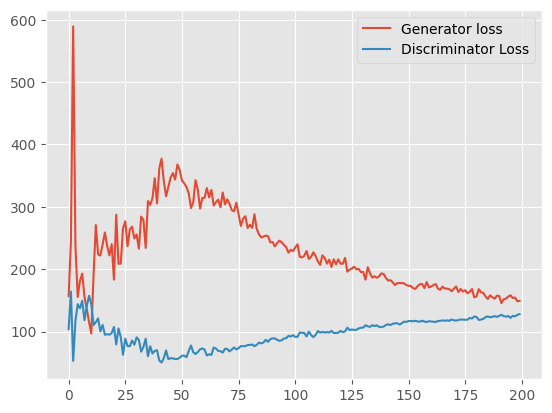

In [ ]:
# 생성자와 판별자의 오차 확인
plt.figure()
losses_g = [f1.item() for f1 in losses_g]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.show()

- 처음 몇 에포크 동안 생성자의 오차는 증가, 판별자의 오차는 감소함.
    - 이유 : 학습 초기 단계에 생성자는 좋은 가짜 이미지 생성하지 못하기 때문에 판별자가 실제 이미지와 가짜 이미지 쉽게 구분할 수 있음.
- 학습 진행됨에 따라 생성자는 진짜와 같은 가짜 이미지 만들며 판별자는 가짜 이미지 중 일부를 진짜로 분류함. 그림과 같이 생성자의 오차가 감소하면 판별자의 오차가 증가함.

In [ ]:
import numpy as np # numpy 라이브러리 import

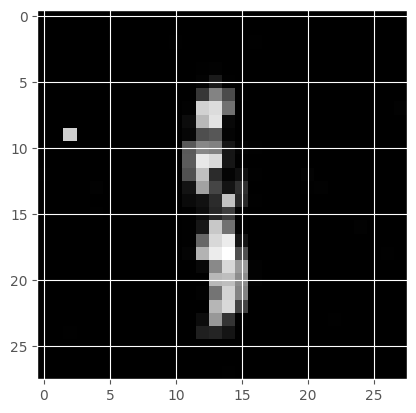

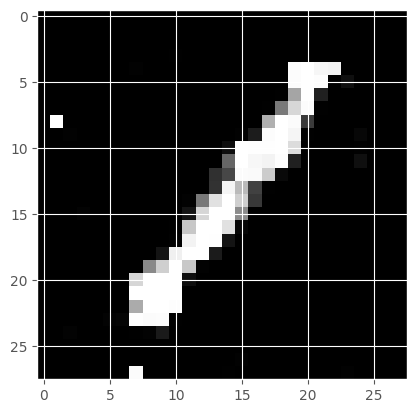

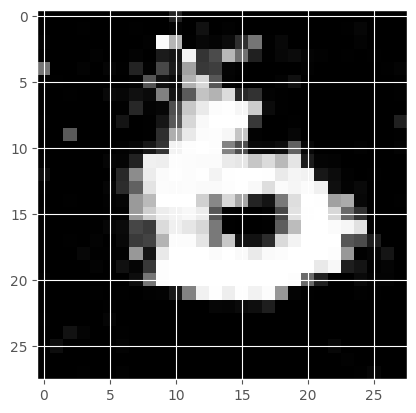

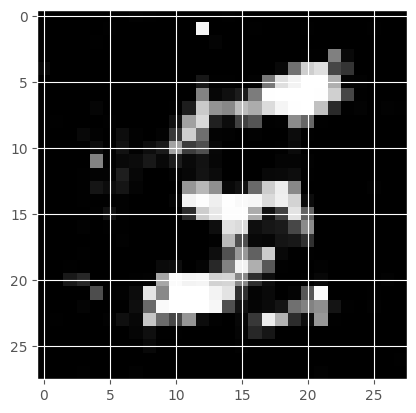

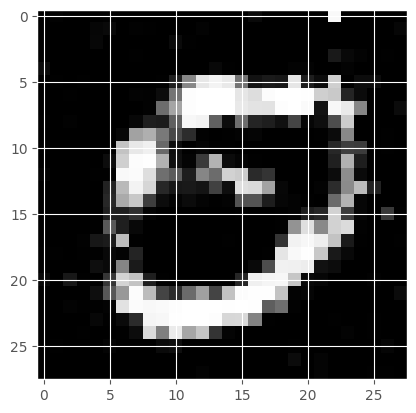

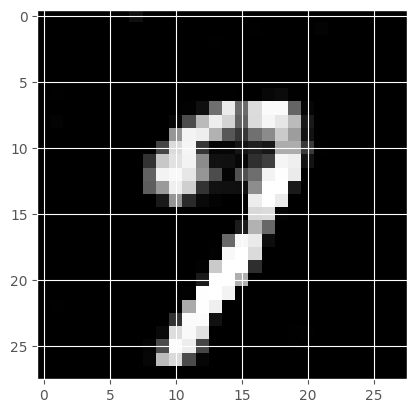

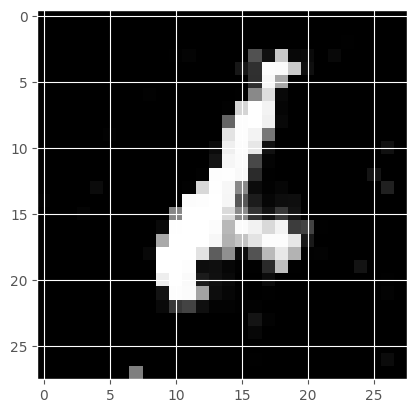

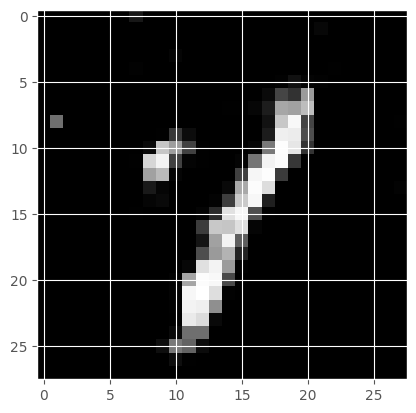

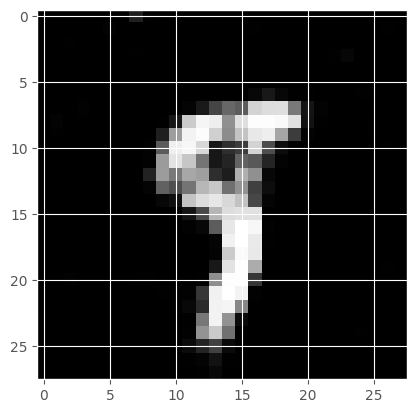

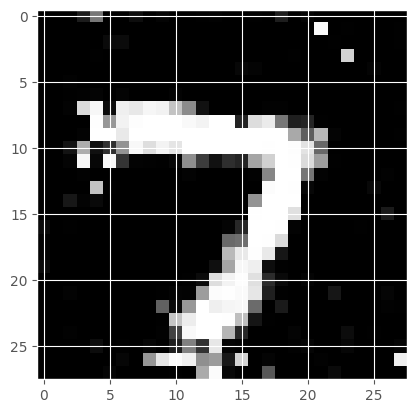

In [ ]:
# 생성된 이미지 출력
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.show()